In [1]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import sys 
sys.path.insert(0, '../src/')
import jsm_mcmc
import jsm_SHMR

In [2]:
def lgMs_B13(lgMv,z=0.):
    r"""
    Log stellar mass [M_sun] given log halo mass and redshift, using the 
    fitting function by Behroozi+13.
    
    Syntax:
    
        lgMs_B13(lgMv,z)
    
    where 
        lgMv: log virial mass [Msun] (float or array)
        z: redshift (float) (default=0.)
    """
    a = 1./(1.+z)
    v = v_B13(a)
    e0 = -1.777
    ea = -0.006
    ez = 0.000
    ea2 = -0.119
    M0 = 11.514
    Ma = -1.793
    Mz = -0.251
    lge = e0 + (ea*(a-1.)+ez*z)*v + ea2*(a-1.)
    lgM = M0 + (Ma*(a-1.)+Mz*z)*v
    return lge+lgM + f_B13(lgMv-lgM,a) - f_B13(0.,a)
def v_B13(a):
    r"""
    Auxiliary function for lgMs_B13.
    """
    return np.exp(-4.*a**2)
def f_B13(x,a):
    r"""
    Auxiliary function for lgMs_B13.
    """
    a0 = -1.412
    aa = 0.731
    az = 0.0
    d0 = 3.508
    da = 2.608
    dz = -0.043
    g0 = 0.316
    ga = 1.319
    gz = 0.279
    v = v_B13(a)
    z = 1./a-1.
    alpha = a0 + (aa*(a-1.)+az*z)*v
    delta = d0 + (da*(a-1.)+dz*z)*v
    gamma = g0 + (ga*(a-1.)+gz*z)*v
    return delta*(np.log10(1.+np.exp(x)))**gamma/(1.+np.exp(10**(-x)))-\
        np.log10(1.+10**(alpha*x))

In [3]:
lgMh = np.linspace(8,12,100)

In [4]:
def SHMR_1D(lgMh, alpha, delta, sigma, Mstar):

    """_summary_
    Convert from halo mass to stellar mass with scatter
    Ms* is a free parameter

    Args:
        lgMh (np.ndarray): 2D halo mass array
        a0: power law slope
        a1: quadratic term to curve the function
        a2: log normal scatter
        a3: the stellar mass anchor point

    Returns:
        np.ndarray: 2D stellar mass array
    """

    M_star_a = Mstar
    M_halo_a = 11.67

    lgMs_2D = alpha*(lgMh-M_halo_a) + delta*(lgMh-M_halo_a)**2 + M_star_a
    scatter_2D = np.random.normal(loc=0, scale=sigma, size=(lgMs_2D.shape))
    return lgMs_2D + scatter_2D

<IPython.core.display.Javascript object>


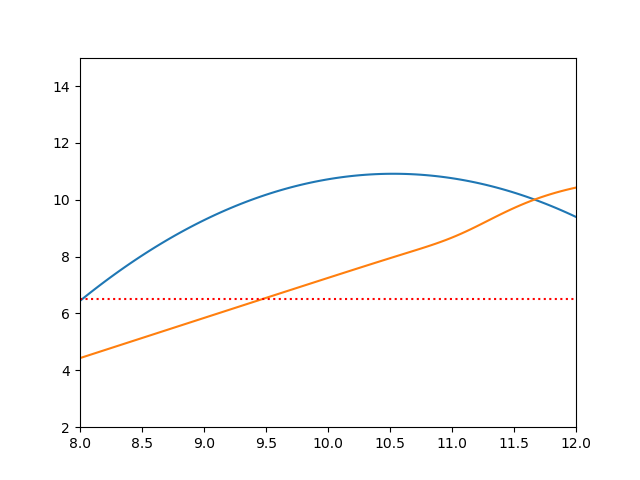

interactive(children=(FloatSlider(value=1.8, description='alpha', max=5.0, min=-5.0), FloatSlider(value=0.0, d…

(8.0, 12.0)

In [5]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(lgMh, SHMR_1D(lgMh, alpha=1, delta=1, sigma=1, Mstar=1))
plt.plot(lgMh, lgMs_B13(lgMh))
plt.axhline(6.5, color="red", ls=":")

def update(alpha = 1.8, delta = 0, sigma = 0, Mstar=10):
    line.set_ydata(SHMR_1D(lgMh,alpha,delta,sigma,Mstar))
    fig.canvas.draw_idle()
    
interact(update, alpha = (-5,5,0.1), delta = (-3,1,0.1), sigma = (0,4,0.1), Mstar=(9,12,0.1));
plt.ylim(2, 15)
plt.xlim(8,12)

Testing the likelyhood

In [9]:
fid_theta = [1.8, -0.2, 0.4, 10.1]
priors = [[-5, 5],[-3, 1],[0, 5], [9,12]]
min_mass = 6.5

In [10]:
massdir = "../../data/MW-analog/meta_data_psi3/"
datadir = "../../data/init_val/testing/"
data = jsm_mcmc.test_data(fid_theta, massdir+"jsm_MCMC.npy", datadir+"data.npy")
data.get_stats(min_mass=min_mass)

In [11]:

def forward(theta):
    models = jsm_mcmc.models(theta, jsm_SHMR.anchor, data.lgMh_models)
    models.get_stats(min_mass=min_mass)
    return models.stat.Pnsat, models.stat.Msmax, models.stat.ecdf_MsMax

def lnlike(theta):
    model_Pnsat, models_Msmax, _ = forward(theta)
    lnL_sat = jsm_mcmc.lnL_Pnsat(model_Pnsat, data.stat.satfreq)
    lnL_max = jsm_mcmc.lnL_KS(models_Msmax, data.stat.Msmax)
    return lnL_sat + lnL_max

def lnprior(theta):
    if priors[0][0] < theta[0] < priors[0][1] and priors[1][0] < theta[1] < priors[1][1] and priors[2][0] < theta[2] < priors[2][1]:
        lp = 0
    else:
        lp = -np.inf
    chi2_pr = ((theta[3] - 10.0) / 0.2) ** 2
    lnLPR = -chi2_pr / 2.0
    return lnLPR + lp

def lnprob(alpha, delta, sigma, Mstar):
    theta = [alpha, delta, sigma, Mstar]
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + lnlike(theta)

In [19]:
lnprob(1.9, 0, 0.1, 10.1)

-306.78669871183786

In [20]:
N = 10

[lnprob(1.9, 0, 0.1, 10.1)]

[-305.27462960045807]

In [22]:
plt.plot(np.arange(N), [lnprob(1.9, 0, 0.1, 10.1)]*N)
plt.show()

<IPython.core.display.Javascript object>


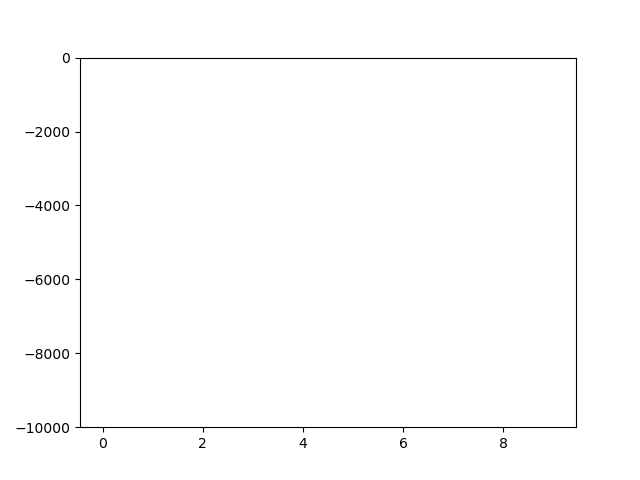

interactive(children=(FloatSlider(value=1.9, description='alpha', max=5.0, min=-5.0), FloatSlider(value=0.0, d…

(-10000.0, 0.0)

In [32]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(np.arange(N), [lnprob(alpha = 1.9, delta = 0, sigma = 0.1, Mstar=10)]*N)

def update(alpha = 1.9, delta = 0, sigma = 0.1, Mstar=10):
    line.set_ydata([lnprob(alpha,delta,sigma,Mstar)]*N)
    fig.canvas.draw_idle()
        
interact(update, alpha = (-5,5,0.1), delta = (-3,1,0.1), sigma = (0,4,0.1), Mstar=(9,12,0.1));
plt.ylim(-10000,0)


In [ ]:
# def sigmaGrow(lgMh_2D, a0, a1, a2, a3):

#     """_summary_
#     Convert from halo mass to stellar mass with a growing scatter

#     Args:
#         lgMh_2D (np.ndarray): 2D halo mass array
#         a0: power law slope
#         a1: quadratic term to curve the function
#         a2: initial value of sigma
#         a3: the power law slope of sigma (needs to be negative)

#     Returns:
#         np.ndarray: 2D stellar mass array
#     """

#     M_star_a = 10
#     M_halo_a = 11.67

#     sigma = a2 + a3*(lgMh_2D - M_halo_a)

#     lgMs_2D = a0*(lgMh_2D-M_halo_a) + a1*(lgMh_2D-M_halo_a)**2 + M_star_a
#     scatter_2D = np.random.normal(loc=0, scale=sigma, size=(lgMs_2D.shape))
#     return lgMs_2D + scatter_2D

In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)
# line, = ax.plot(lgMh, sigmaGrow(lgMh, a0=1, a1=1, a2=0, a3=0))
# plt.plot(lgMh, lgMs_B13(lgMh))
# plt.axhline(6.5, color="red", ls=":")

# def update(a0 = 1.9, a1=-0.2, a2=0, a3=0):
#     line.set_ydata(sigmaGrow(lgMh,a0,a1,a2,a3))
#     fig.canvas.draw_idle()
    
# interact(update, a0 = (-1,3,0.1), a1 = (-2,0.5,0.1), a2 = (0,1,0.01), a3=(-2, 0,0.1));
# plt.ylim(0, 15)
# plt.xlim(4,12)

In [ ]:
# def sigma(lgMh, intercept, slope):
#     return intercept + slope*(lgMh - 12)

In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)
# line, = ax.plot(lgMh, sigma(lgMh, intercept=0, slope=0))
# plt.axhline(0, color="red", ls=":")

# def update(a2=0, a3=0):
#     line.set_ydata(sigma(lgMh,a2,a3))
#     fig.canvas.draw_idle()
    
# interact(update, a2 = (0,1,0.01), a3=(-2, 0,0.001));
# plt.ylim(-0.1, 1)